Your own few-shot classification model ready in 15mn with PyTorch

Notebook taken from: [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sicara/easy-few-shot-learning/blob/master/notebooks/my_first_few_shot_classifier.ipynb)

 Discovering Prototypical Networks

In [ ]:
!pip install easyfsl==1.1.0

In [1]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import Flowers102
from torchvision.models import resnet18
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from torch.optim.lr_scheduler import MultiStepLR

In [4]:
from easyfsl.samplers import TaskSampler
from easyfsl.utils import plot_images, sliding_average
from torch import nn, Tensor
from easyfsl.methods import FewShotClassifier
from easyfsl.modules.predesigned_modules import (
    default_matching_networks_support_encoder,
    default_matching_networks_query_encoder,
)
import random
from easyfsl.methods import FewShotClassifier
from easyfsl.modules.predesigned_modules import (
    default_matching_networks_support_encoder,
    default_matching_networks_query_encoder,
)

In [5]:
from torch.utils.data import DataLoader
from torchvision.datasets import Flowers102
from torchvision import transforms

In [6]:
batch_size = 64
n_workers = 12
image_size = 224
train_set = Flowers102(
    root="./data",
    split = 'train',
    transform=transforms.Compose(
        [
            transforms.RandomResizedCrop(image_size),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
        ]
    ),
    download=True,
)

100%|██████████| 344862509/344862509 [00:10<00:00, 34326137.70it/s]


Extracting data/flowers-102/102flowers.tgz to data/flowers-102


100%|██████████| 502/502 [00:00<00:00, 894072.45it/s]


100%|██████████| 14989/14989 [00:00<00:00, 14442550.58it/s]


In [7]:
val_set = Flowers102(
    root="./data",
    split = 'val',
    transform=transforms.Compose(
        [
            transforms.RandomResizedCrop(image_size),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
        ]
    ),
    download=True,
)

In [8]:
test_set = Flowers102(
    root="./data",
    split = 'test',
    transform=transforms.Compose(
        [
            transforms.RandomResizedCrop(image_size),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
        ]
    ),
    download=True,
)


'<br>
Modified prototypical network to train a siamese version of the embedder network<br>


In [9]:
class PrototypicalNetworks(nn.Module):
    def __init__(self, backbone: nn.Module):
        super(PrototypicalNetworks, self).__init__()
        self.backbone = backbone

    def return_a_p_n( self,
        support_images: torch.Tensor,
        support_labels: torch.Tensor,
        query_images: torch.Tensor,
        query_labels: torch.Tensor):
        '''
        This function outputs the embedding for the anchor, positive and negative images.
        The function picks an anchor label at random from the support set. The positive and negative images
        are picked up from the query set.
        The function is called during model.fit for triplet loss calculation
        '''

        z_support = self.backbone.forward(support_images)
        z_query = self.backbone.forward(query_images)
        label = random.choice(support_labels)

        anchor = torch.cat([z_support[torch.nonzero(support_labels == label)]])
        anchor = torch.reshape(anchor, (anchor.shape[0],anchor.shape[-1]))

        positive = torch.cat([z_query[torch.nonzero(query_labels == label)]])
        positive = torch.reshape(positive, (positive.shape[0],positive.shape[-1]))
        negative = torch.cat([z_query[torch.nonzero(query_labels != label)]])

        negative = torch.reshape(negative, (negative.shape[0],negative.shape[-1]))
        #print(negative.shape)

        return anchor,positive,negative

    def forward(
        self,
        support_images: torch.Tensor,
        support_labels: torch.Tensor,
        query_images: torch.Tensor,
    ) -> torch.Tensor:
        """
        Predict query labels using labeled support images.
        """
        # Extract the features of support and query images
        z_support = self.backbone.forward(support_images)
        z_query = self.backbone.forward(query_images)



        # Infer the number of different classes from the labels of the support set
        n_way = len(torch.unique(support_labels))
        # Prototype i is the mean of all instances of features corresponding to labels == i
        z_proto = torch.cat(
            [
                z_support[torch.nonzero(support_labels == label)].mean(0)
                for label in range(n_way)
            ]
        )
        # Compute the euclidean distance from queries to prototypes
        dists = torch.cdist(z_query, z_proto)

        # And here is the super complicated operation to transform those distances into classification scores!
        scores = -dists
        return scores
convolutional_network = resnet18(pretrained=True)
convolutional_network.fc =  nn.Sequential(
    nn.Flatten(),nn.Linear(512,512)).to('cuda')

print(convolutional_network)

model = PrototypicalNetworks(convolutional_network).cuda()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 136MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [10]:
N_WAY = 5 # Number of classes in a task
N_SHOT = 4  # Number of images per class in the support set
N_QUERY = 5  # Number of images per class in the query set
N_EVALUATION_TASKS = 500

The sampler needs a dataset with a "get_labels" method. Check the code if you have any doubt!

In [11]:
test_set.get_labels = lambda: [instance[1] for instance in test_set]
test_sampler = TaskSampler(
    test_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS
)

In [12]:
test_loader = DataLoader(
    test_set,
    batch_sampler=test_sampler,
    num_workers=12,
    pin_memory=True,
    collate_fn=test_sampler.episodic_collate_fn,
)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(



We created a dataloader that will feed us with 5-way 5-shot tasks (the most common setting in the litterature).<br>
Now, as every data scientist should do before launching opaque training scripts,<br>
let's take a look at our dataset.<br>


In [13]:
(
    example_support_images,
    example_support_labels,
    example_query_images,
    example_query_labels,
    example_class_ids,
) = next(iter(test_loader))

lot_images(example_support_images, "support images", images_per_row=N_SHOT)<br>
lot_images(example_query_images, "query images", images_per_row=N_QUERY)


For both support and query set, you should have one line for each class.<br>
How does our model perform on this task?<br>


In [14]:
model.eval()
example_scores = model(
    example_support_images.cuda(),
    example_support_labels.cuda(),
    example_query_images.cuda()
).detach()

In [15]:
_, example_predicted_labels = torch.max(example_scores.data, 1)

In [ ]:
# print("Ground Truth / Predicted")
# for i in range(len(example_query_labels)):
#     print(f"{example_scores} / {example_predicted_labels}")


This doesn't look bad: keep in mind that the model was trained on very different images, and has only seen 5 examples for each class!<br>
Now that we have a first idea, let's see more precisely how good our model is.<br>


In [18]:
def evaluate_on_one_task(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
):
    """
    Returns the number of correct predictions of query labels, and the total number of predictions.
    """
    model.eval()
    return (
        torch.max(
            model(support_images.cuda(), support_labels.cuda(),query_images.cuda())
            .detach()
            .data,
            1,
        )[1]
        == query_labels.cuda()
    ).sum().item(), len(query_labels)

In [19]:
def evaluate(data_loader: DataLoader):
    # We'll count everything and compute the ratio at the end
    total_predictions = 0
    correct_predictions = 0

    # eval mode affects the behaviour of some layers (such as batch normalization or dropout)
    # no_grad() tells torch not to keep in memory the whole computational graph (it's more lightweight this way)
    model.eval()
    with torch.no_grad():
        for episode_index, (
            support_images,
            support_labels,
            query_images,
            query_labels,
            class_ids,
        ) in tqdm(enumerate(data_loader), total=len(data_loader)):
            correct, total = evaluate_on_one_task(
                support_images, support_labels, query_images, query_labels
            )
            total_predictions += total
            correct_predictions += correct
    print(
        f"Model tested on {len(data_loader)} tasks. Accuracy: {(100 * correct_predictions/total_predictions):.2f}%"
    )
    return correct_predictions / total_predictions

In [20]:
evaluate(test_loader)

100%|██████████| 500/500 [01:53<00:00,  4.40it/s]

Model tested on 500 tasks. Accuracy: 83.22%


0.83224

With absolutely zero training on Flowers images, and only 5 examples per class, we achieve around 83.2% accuracy!

## Training Meta Learning classifier

In [21]:
N_TRAINING_EPISODES_PER_EPOCH = 100
N_VALIDATION_TASKS = 100

In [22]:
train_set.get_labels = lambda: [instance[1] for instance in train_set]
train_sampler = TaskSampler(
    train_set, n_way=2, n_shot=5, n_query=5, n_tasks=N_TRAINING_EPISODES_PER_EPOCH
)
train_loader = DataLoader(
    train_set,
    batch_sampler=train_sampler,
    num_workers=12,
    pin_memory=True,
    collate_fn=train_sampler.episodic_collate_fn,
)

In [23]:
val_set.get_labels = lambda: [instance[1] for instance in val_set]
val_sampler = TaskSampler(
    val_set, n_way=2, n_shot=5, n_query=5, n_tasks=N_VALIDATION_TASKS
)
val_loader = DataLoader(
    val_set,
    batch_sampler=val_sampler,
    num_workers=12,
    pin_memory=True,
    collate_fn=val_sampler.episodic_collate_fn,
)

In [24]:
criterion = nn.TripletMarginLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
n_epochs = 40
scheduler_milestones = [120, 160]
scheduler_gamma = 0.1
learning_rate = 1e-2
train_scheduler = MultiStepLR(
    optimizer,
    milestones=scheduler_milestones,
    gamma=scheduler_gamma,
)

In [25]:
def fit(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> float:
    optimizer.zero_grad()
    # model.process_support_set()
    a,p,n = model.return_a_p_n(
        support_images.cuda(), support_labels.cuda(),
        query_images.cuda(), query_labels.cuda()
    )

    loss = criterion(a.cuda(),p.cuda(),n.cuda())
    loss.backward()
    optimizer.step()

    return loss.item()


To train the model, we are just going to iterate over a large number of randomly generated few-shot classification tasks,<br>
and let the `fit` method update our model after each task. This is called **episodic training**.<br>


Train the model yourself with this cell

In [26]:
def training_epoch(
    model: FewShotClassifier, data_loader: DataLoader):
    log_update_frequency = 10
    all_loss = []
    model.train()
    with tqdm(enumerate(data_loader), total=len(data_loader), desc="Training") as tqdm_train:
        for episode_index, (
                support_images,
                support_labels,
                query_images,
                query_labels,
                _,
            ) in tqdm_train:
            loss_value = fit(support_images, support_labels, query_images, query_labels)
            #loss_value is a float
            all_loss.append(loss_value)
            if episode_index % log_update_frequency == 0:
                tqdm_train.set_postfix(loss=sliding_average(all_loss, log_update_frequency))
    return np.mean(all_loss)

In [27]:
def validate_epoch(
    model: FewShotClassifier, data_loader: DataLoader):
    val_loss=0.0
    val_correct=0.0
    val_loss_history=[]
    val_correct_history=[]
    model.eval()

    with torch.no_grad():
        with tqdm(enumerate(data_loader), total=len(data_loader), desc="Validating") as tqdm_train:
            for episode_index, (
                    support_images,
                    support_labels,
                    query_images,
                    query_labels,
                    _,
                ) in tqdm_train:
                classification_scores = model(support_images.cuda(), support_labels.cuda(),query_images.cuda()
                )
                a,p,n = model.return_a_p_n(
                    support_images.cuda(), support_labels.cuda(),
                    query_images.cuda(), query_labels.cuda()
                )

                loss_value = criterion(a.cuda(),n.cuda(),p.cuda())

                _,val_preds=torch.max(classification_scores ,1)
                val_loss+=loss_value.item()
                val_correct+=torch.sum(val_preds==query_labels.cuda().data)
                val_epoch_loss=val_loss/len(data_loader)
                val_epoch_acc=val_correct.float()/len(data_loader)
                val_loss_history.append(val_epoch_loss)
                val_correct_history.append(val_epoch_acc)
    return val_epoch_loss

Training and Validation!

In [28]:
val_results = []
train_loss_results = []
val_loss_results = []
train_results = []
best_state = model.state_dict()
best_validation_accuracy = 0.0
for epoch in range(n_epochs):
    print(f"Epoch {epoch}")
    average_loss = training_epoch(model, train_loader)
    train_loss_results.append(average_loss)
    average_val_loss = validate_epoch(model, val_loader)
    val_loss_results.append(average_val_loss)
    validation_accuracy = evaluate(val_loader)
    val_results.append(validation_accuracy)
    train_accuracy = evaluate(train_loader)
    train_results.append(train_accuracy)
    if validation_accuracy > best_validation_accuracy:
        best_validation_accuracy = validation_accuracy
        best_state = model.state_dict()
        print(f"We found a new best model! with val accuracy {best_validation_accuracy}")
    # Warn the scheduler that we did an epoch
    # so it knows when to decrease the learning rate
    train_scheduler.step()

100%|██████████| 100/100 [00:11<00:00,  8.91it/s]

Model tested on 100 tasks. Accuracy: 68.40%



100%|██████████| 100/100 [00:11<00:00,  8.60it/s]

Model tested on 100 tasks. Accuracy: 63.80%
We found a new best model! with val accuracy 0.684
Epoch 3



100%|██████████| 100/100 [00:10<00:00,  9.80it/s]

Model tested on 100 tasks. Accuracy: 67.50%



100%|██████████| 100/100 [00:10<00:00,  9.98it/s]

Model tested on 100 tasks. Accuracy: 69.60%
Epoch 4



100%|██████████| 100/100 [00:11<00:00,  9.00it/s]

Model tested on 100 tasks. Accuracy: 67.60%



100%|██████████| 100/100 [00:11<00:00,  8.73it/s]

Model tested on 100 tasks. Accuracy: 71.40%
Epoch 5



100%|██████████| 100/100 [00:10<00:00,  9.97it/s]

Model tested on 100 tasks. Accuracy: 66.00%



100%|██████████| 100/100 [00:09<00:00, 10.11it/s]

Model tested on 100 tasks. Accuracy: 70.90%
Epoch 6



100%|██████████| 100/100 [00:11<00:00,  9.00it/s]

Model tested on 100 tasks. Accuracy: 71.80%



100%|██████████| 100/100 [00:11<00:00,  8.86it/s]

Model tested on 100 tasks. Accuracy: 75.70%
We found a new best model! with val accuracy 0.718
Epoch 7



100%|██████████| 100/100 [00:09<00:00, 10.30it/s]

Model tested on 100 tasks. Accuracy: 72.60%



100%|██████████| 100/100 [00:10<00:00,  9.77it/s]

Model tested on 100 tasks. Accuracy: 77.60%
We found a new best model! with val accuracy 0.726
Epoch 8



100%|██████████| 100/100 [00:11<00:00,  8.80it/s]

Model tested on 100 tasks. Accuracy: 73.40%



100%|██████████| 100/100 [00:11<00:00,  8.92it/s]

Model tested on 100 tasks. Accuracy: 79.40%
We found a new best model! with val accuracy 0.734
Epoch 9



100%|██████████| 100/100 [00:09<00:00, 10.64it/s]

Model tested on 100 tasks. Accuracy: 67.50%



100%|██████████| 100/100 [00:11<00:00,  8.77it/s]

Model tested on 100 tasks. Accuracy: 72.80%
Epoch 10



100%|██████████| 100/100 [00:11<00:00,  8.71it/s]

Model tested on 100 tasks. Accuracy: 72.70%



100%|██████████| 100/100 [00:11<00:00,  8.97it/s]

Model tested on 100 tasks. Accuracy: 73.40%
Epoch 11



100%|██████████| 100/100 [00:10<00:00,  9.73it/s]

Model tested on 100 tasks. Accuracy: 73.70%



100%|██████████| 100/100 [00:11<00:00,  8.75it/s]

Model tested on 100 tasks. Accuracy: 71.80%
We found a new best model! with val accuracy 0.737
Epoch 12



100%|██████████| 100/100 [00:10<00:00,  9.11it/s]

Model tested on 100 tasks. Accuracy: 69.60%



100%|██████████| 100/100 [00:10<00:00,  9.49it/s]

Model tested on 100 tasks. Accuracy: 79.40%
Epoch 13



100%|██████████| 100/100 [00:10<00:00,  9.21it/s]

Model tested on 100 tasks. Accuracy: 83.10%



100%|██████████| 100/100 [00:11<00:00,  8.93it/s]

Model tested on 100 tasks. Accuracy: 80.40%
We found a new best model! with val accuracy 0.831
Epoch 14



100%|██████████| 100/100 [00:10<00:00,  9.49it/s]

Model tested on 100 tasks. Accuracy: 71.90%



100%|██████████| 100/100 [00:09<00:00, 10.36it/s]

Model tested on 100 tasks. Accuracy: 70.20%
Epoch 15



100%|██████████| 100/100 [00:11<00:00,  9.06it/s]

Model tested on 100 tasks. Accuracy: 74.90%



100%|██████████| 100/100 [00:11<00:00,  8.90it/s]

Model tested on 100 tasks. Accuracy: 76.30%
Epoch 16



100%|██████████| 100/100 [00:09<00:00, 10.19it/s]

Model tested on 100 tasks. Accuracy: 73.60%



100%|██████████| 100/100 [00:10<00:00,  9.97it/s]

Model tested on 100 tasks. Accuracy: 71.30%
Epoch 17



100%|██████████| 100/100 [00:10<00:00,  9.17it/s]

Model tested on 100 tasks. Accuracy: 81.00%



100%|██████████| 100/100 [00:11<00:00,  9.07it/s]

Model tested on 100 tasks. Accuracy: 74.80%
Epoch 18



100%|██████████| 100/100 [00:09<00:00, 10.36it/s]

Model tested on 100 tasks. Accuracy: 77.60%



100%|██████████| 100/100 [00:11<00:00,  8.82it/s]

Model tested on 100 tasks. Accuracy: 73.50%
Epoch 19



100%|██████████| 100/100 [00:11<00:00,  8.73it/s]

Model tested on 100 tasks. Accuracy: 80.10%



100%|██████████| 100/100 [00:11<00:00,  8.80it/s]

Model tested on 100 tasks. Accuracy: 81.30%
Epoch 20



100%|██████████| 100/100 [00:09<00:00, 10.56it/s]

Model tested on 100 tasks. Accuracy: 77.40%



100%|██████████| 100/100 [00:11<00:00,  8.81it/s]

Model tested on 100 tasks. Accuracy: 76.90%
Epoch 21



100%|██████████| 100/100 [00:11<00:00,  8.92it/s]

Model tested on 100 tasks. Accuracy: 78.50%



100%|██████████| 100/100 [00:11<00:00,  8.75it/s]

Model tested on 100 tasks. Accuracy: 77.60%
Epoch 22



100%|██████████| 100/100 [00:09<00:00, 10.03it/s]

Model tested on 100 tasks. Accuracy: 77.40%



100%|██████████| 100/100 [00:11<00:00,  8.72it/s]

Model tested on 100 tasks. Accuracy: 75.60%
Epoch 23



100%|██████████| 100/100 [00:11<00:00,  8.79it/s]

Model tested on 100 tasks. Accuracy: 73.00%



100%|██████████| 100/100 [00:11<00:00,  8.99it/s]

Model tested on 100 tasks. Accuracy: 74.20%
Epoch 24



100%|██████████| 100/100 [00:10<00:00,  9.51it/s]

Model tested on 100 tasks. Accuracy: 72.80%



100%|██████████| 100/100 [00:11<00:00,  8.91it/s]

Model tested on 100 tasks. Accuracy: 75.10%
Epoch 25



100%|██████████| 100/100 [00:11<00:00,  8.79it/s]

Model tested on 100 tasks. Accuracy: 74.80%



100%|██████████| 100/100 [00:11<00:00,  8.56it/s]

Model tested on 100 tasks. Accuracy: 76.50%
Epoch 26



100%|██████████| 100/100 [00:10<00:00,  9.47it/s]

Model tested on 100 tasks. Accuracy: 79.70%



100%|██████████| 100/100 [00:11<00:00,  8.89it/s]

Model tested on 100 tasks. Accuracy: 72.70%
Epoch 27



100%|██████████| 100/100 [00:11<00:00,  8.80it/s]

Model tested on 100 tasks. Accuracy: 78.30%



100%|██████████| 100/100 [00:11<00:00,  8.68it/s]

Model tested on 100 tasks. Accuracy: 77.40%
Epoch 28



100%|██████████| 100/100 [00:09<00:00, 10.40it/s]

Model tested on 100 tasks. Accuracy: 79.30%



100%|██████████| 100/100 [00:10<00:00,  9.15it/s]

Model tested on 100 tasks. Accuracy: 81.30%
Epoch 29



100%|██████████| 100/100 [00:11<00:00,  8.76it/s]

Model tested on 100 tasks. Accuracy: 74.30%



100%|██████████| 100/100 [00:11<00:00,  8.83it/s]

Model tested on 100 tasks. Accuracy: 74.50%
Epoch 30



100%|██████████| 100/100 [00:09<00:00, 10.36it/s]

Model tested on 100 tasks. Accuracy: 79.50%



100%|██████████| 100/100 [00:11<00:00,  8.77it/s]

Model tested on 100 tasks. Accuracy: 76.90%
Epoch 31



100%|██████████| 100/100 [00:11<00:00,  8.64it/s]

Model tested on 100 tasks. Accuracy: 74.40%



100%|██████████| 100/100 [00:11<00:00,  8.69it/s]

Model tested on 100 tasks. Accuracy: 76.20%
Epoch 32



100%|██████████| 100/100 [00:09<00:00, 10.35it/s]

Model tested on 100 tasks. Accuracy: 77.00%



100%|██████████| 100/100 [00:10<00:00,  9.23it/s]

Model tested on 100 tasks. Accuracy: 76.10%
Epoch 33



100%|██████████| 100/100 [00:11<00:00,  8.95it/s]

Model tested on 100 tasks. Accuracy: 72.40%



100%|██████████| 100/100 [00:11<00:00,  8.81it/s]

Model tested on 100 tasks. Accuracy: 74.80%
Epoch 34



100%|██████████| 100/100 [00:10<00:00,  9.67it/s]

Model tested on 100 tasks. Accuracy: 68.40%



100%|██████████| 100/100 [00:09<00:00, 10.01it/s]

Model tested on 100 tasks. Accuracy: 72.10%
Epoch 35



100%|██████████| 100/100 [00:11<00:00,  8.93it/s]

Model tested on 100 tasks. Accuracy: 72.10%



100%|██████████| 100/100 [00:11<00:00,  8.73it/s]

Model tested on 100 tasks. Accuracy: 67.60%
Epoch 36



100%|██████████| 100/100 [00:11<00:00,  8.83it/s]

Model tested on 100 tasks. Accuracy: 70.60%



100%|██████████| 100/100 [00:09<00:00, 10.17it/s]

Model tested on 100 tasks. Accuracy: 73.20%
Epoch 37



100%|██████████| 100/100 [00:11<00:00,  8.83it/s]

Model tested on 100 tasks. Accuracy: 72.80%



100%|██████████| 100/100 [00:11<00:00,  8.68it/s]

Model tested on 100 tasks. Accuracy: 68.50%
Epoch 38



100%|██████████| 100/100 [00:11<00:00,  8.80it/s]

Model tested on 100 tasks. Accuracy: 78.90%



100%|██████████| 100/100 [00:10<00:00,  9.24it/s]

Model tested on 100 tasks. Accuracy: 76.10%
Epoch 39



100%|██████████| 100/100 [00:10<00:00,  9.60it/s]

Model tested on 100 tasks. Accuracy: 72.80%



100%|██████████| 100/100 [00:11<00:00,  8.78it/s]

Model tested on 100 tasks. Accuracy: 68.80%


Testing

In [38]:
evaluate(test_loader)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 500/500 [01:58<00:00,  4.21it/s]

Model tested on 500 tasks. Accuracy: 44.12%


0.4412

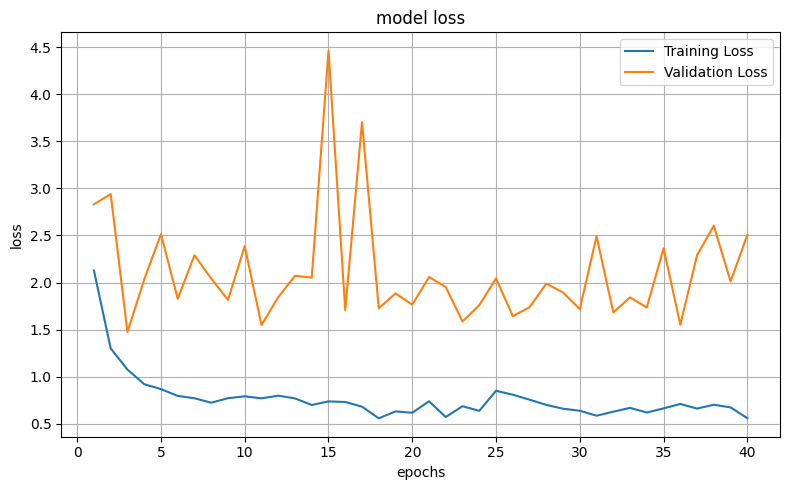

In [39]:
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8,5))
plt.plot(range(1,len(train_loss_results)+1),train_loss_results, label='Training Loss')
plt.plot(range(1,len(val_loss_results)+1),val_loss_results,label='Validation Loss')

plt.title('model loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

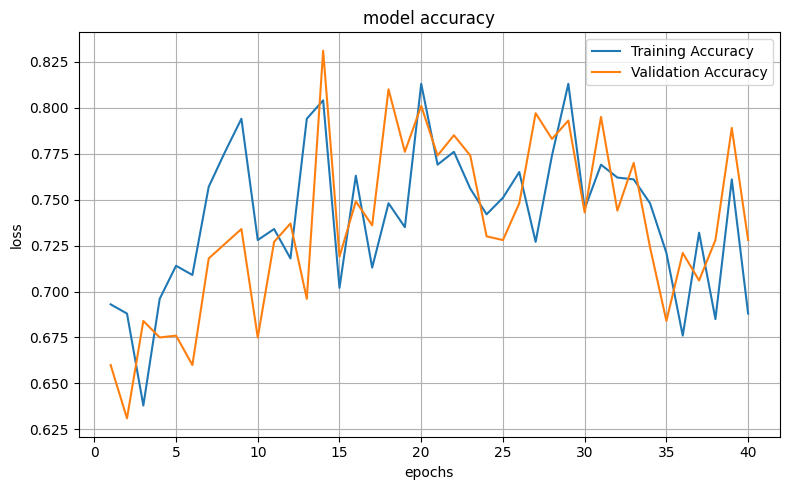

In [40]:
fig = plt.figure(figsize=(8,5))
plt.plot(range(1,len(train_results)+1),train_results, label='Training Accuracy')
plt.plot(range(1,len(val_results)+1),val_results,label='Validation Accuracy')

plt.title('model accuracy')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [36]:
model_save_name = 'proto_custom_triplet.pt'
path = F"/content/drive/MyDrive/CE4042 Assignment/Few-Shot-Learning-main/models/{model_save_name}"
torch.save(best_state, path)

In [37]:
model_save_name = 'proto_custom_triplet.pt'
path = F"/content/drive/MyDrive/CE4042 Assignment/Few-Shot-Learning-main/models/{model_save_name}"
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [35]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
